In [1]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib.patches as mpatches
from shapely import geometry
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt.style.use('seaborn')

C:\Users\mdomi\AppData\Local\Temp\ipykernel_24504\2445562972.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


---
title: "Feature Space analysis of domain shift"
subtitle : "(Tanzania Vs. Ivory Coast)"
author: "Martín Domínguez Durán"
date: today
format: 
    revealjs:
        theme: simple
        toc: true
        toc-depth: 2
        slide-number: true
        logo: ../imgs/WUR_Logo.png
        footer: Martín Domínguez Durán
        transition: fade
        smaller: true
---

In [2]:
ee.Initialize()

In [3]:
# Code to divide ivory coast vector data in 6 so it can be handle by google earth engine
Ivy_qn = gpd.read_file('../Data/Vector/Cashew_Ivorycoast.shp').explode().to_crs('EPSG:2041')
minX, minY, maxX, maxY = Ivy_qn.total_bounds

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = (maxX - minX)/2.5
while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:2041')

C:\Users\mdomi\AppData\Local\Temp\ipykernel_17152\2777370558.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  Ivy_qn = gpd.read_file('../Data/Vector/Cashew_Ivorycoast.shp').explode().to_crs('EPSG:2041')


## Histograms

In [4]:
date_beg = '2015-12-01'
date_end = '2016-12-31'

aoi_T = geemap.shp_to_ee('../Data/Vector/Cashew_Tanzania.shp')
# aoi_C = geemap.geojson_to_ee('ivcst1.geojson')

Pl = (
        ee.ImageCollection('projects/planet-nicfi/assets/basemaps/africa')
        .filterDate(date_beg, date_end)
        .select(['B','G','R','N'])
    )

tz = Pl.map(lambda im : im.clip(aoi_T)).getRegion(aoi_T, scale = 100).getInfo()
df_tz = pd.DataFrame(tz[1:], columns = tz[0]).iloc[:,-4:]
df_tz.columns = [i + '_TNZ' for i in list(df_tz.columns)]

Big_gdf = pd.DataFrame([])

for i in range(len(fishnet)):
    gdf = gpd.clip(Ivy_qn, fishnet.iloc[i].geometry)

    aoi_Iv = geemap.geopandas_to_ee(gdf)

    Precip = Pl.filter(ee.Filter.date(date_beg, date_end))

    data_prec = Precip.getRegion(aoi_Iv, scale = 100).getInfo()

    precip_df = pd.DataFrame(columns= data_prec[0], data = data_prec[1:])

    Big_gdf = Big_gdf.append(precip_df)

Big_gdf.columns = [i + '_IVYCST' for i in list(Big_gdf.columns)]

df = df_tz.append(Big_gdf)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_17152\3698659381.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_17152\3698659381.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_17152\3698659381.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_17152\3698659381.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_

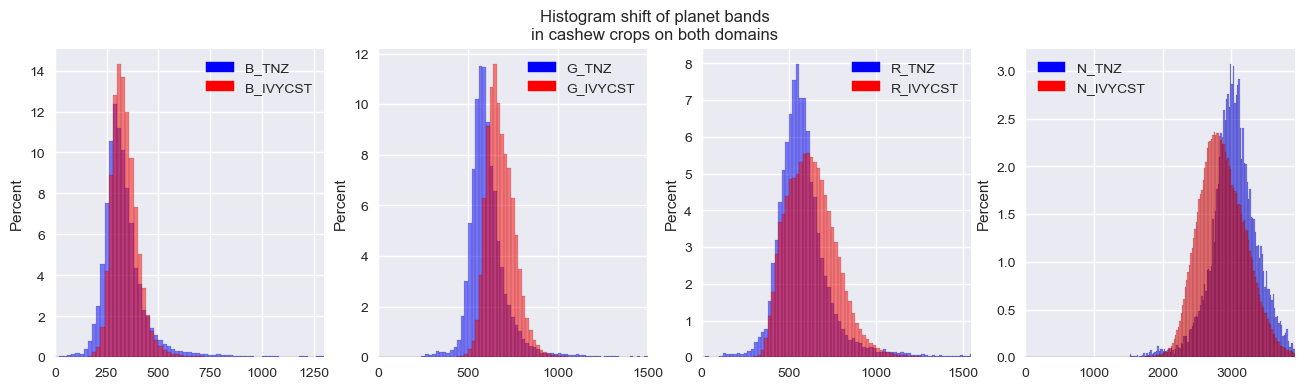

In [5]:
fig, ax = plt.subplots(1,4, figsize = (16,4))

for i in range(4):
    histT = sns.histplot(df.iloc[:, [i]], ax = ax[i], stat = 'percent', palette = ['blue'], bins = np.arange(0, 5000, 20))
    histI = sns.histplot(df.iloc[:, [i+8]], ax = ax[i], stat = 'percent', palette = ['red'], bins = np.arange(0, 5000,20))
#      # i+8
    ax[i].set_xlim(0, np.max(df.iloc[:, [i, i+8]].quantile(0.98)))
    
    red_patch = mpatches.Patch(color='red', label=df.iloc[:, [i+8]].columns[0])
    blu_patch = mpatches.Patch(color='blue', label=df.iloc[:, [i]].columns[0])
    
    ax[i].legend(handles=[blu_patch, red_patch])

sst = plt.suptitle('Histogram shift of planet bands\nin cashew crops on both domains')

In [6]:
X = df_tz.dropna()
X['domain'] = 'target'
X.columns = ['B', 'G', 'R', 'NIR', 'domain']
civ = Big_gdf.iloc[:,-4:]
civ = civ.dropna()
civ['domain'] = 'source'
civ.columns = X.columns

X = X.append(civ)

label = X.iloc[:,-1]

X = X.iloc[:,:4]
# Normalization
X = (X - X.mean())/(X.std())

X

C:\Users\mdomi\AppData\Local\Temp\ipykernel_17152\3452189832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['domain'] = 'target'
C:\Users\mdomi\AppData\Local\Temp\ipykernel_17152\3452189832.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(civ)


,B,G,R,NIR
1,0.361063,-0.488497,-0.086980,-0.564871
2,-1.237043,-2.181324,-1.868223,-1.935043
4,0.066675,-0.815613,-0.645456,-1.008573
5,0.033031,-0.570276,-0.328006,0.196955
7,-0.379113,-1.420779,-1.292111,-1.898765
...,...,...,...,...
7006,0.327419,0.541919,0.783066,0.261138
7007,0.369474,0.640054,0.718400,0.305787
7008,0.159197,0.443784,1.024092,-0.015129
7009,0.377885,0.574631,0.883003,-0.026291


## Principal Component Analysis and t-SNE

t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In [7]:
comps = 2

In [8]:
pca = PCA(comps)

X_pca = pca.fit_transform(X)

<Axes: >

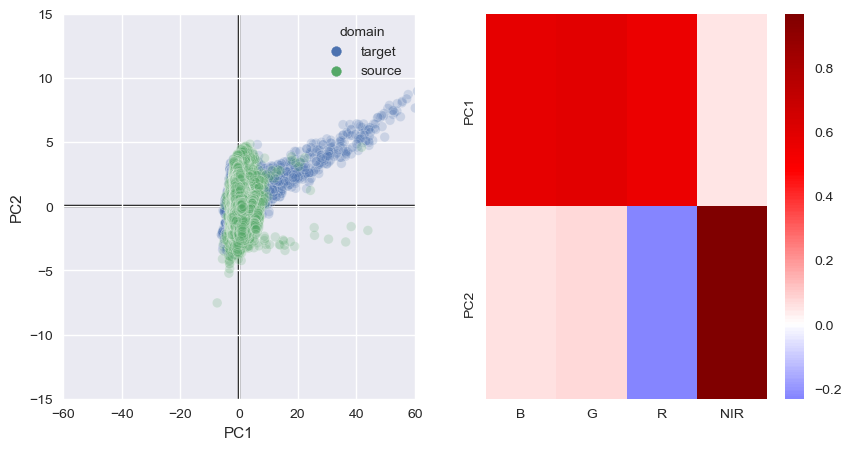

In [24]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = label, alpha = 0.2, ax = ax[0])

ax[0].set_xlim((-60,60))
ax[0].set_ylim((-15,15))

ax[0].axhline(0, color = 'k', zorder = -1)
ax[0].axvline(0, color = 'k', zorder = -1)

ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')

sns.heatmap(pca.components_, cmap = 'seismic', center = 0, ax = ax[1],
            xticklabels=['B', 'G', 'R', 'NIR'],
            yticklabels=['PC'+str(i+1) for i in range(comps)])

In [ ]:
for perplex in [5,30,50]:

    fig = plt.figure()
    
    tsne = TSNE(comps, perplexity = perplex)
    
    X_tsne = tsne.fit_transform(X)
    sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1], hue = label, alpha = 0.05)